# SOUND SIGNAL CLASSIFICATION USING DEEP LEARNING

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import librosa
from scipy.io import wavfile as wav
from tqdm import tqdm
from scipy import ndimage
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn import metrics
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn
import torch.optim as optim
from datetime import datetime
from warnings import filterwarnings
filterwarnings("ignore")

2024-01-03 05:24:06.196593: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-03 05:24:06.196630: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-03 05:24:06.196654: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-03 05:24:06.205951: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-03 05:24:07.014609: W tensorflow/compiler/

In [2]:
try:
    # if use GPU, use it
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using {torch.cuda.get_device_name()} for training." if torch.cuda.is_available() else "Using CPU for training.")
except:
    print("No GPU found. Using CPU.")
    device = torch.device("cpu")

Using NVIDIA GeForce RTX 3060 Ti for training.


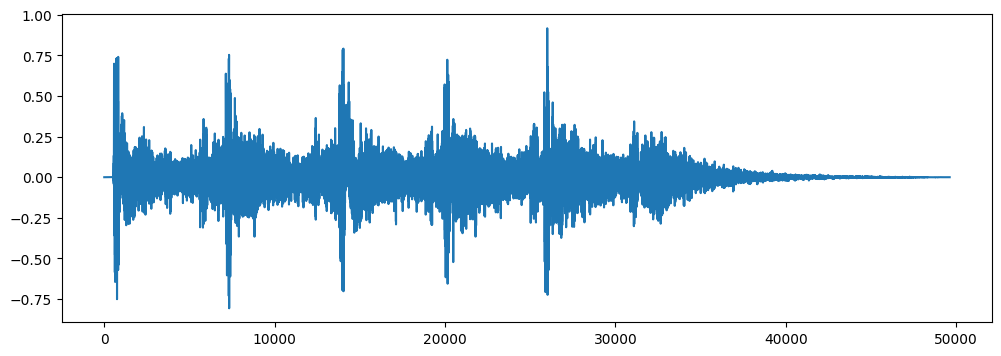

44100


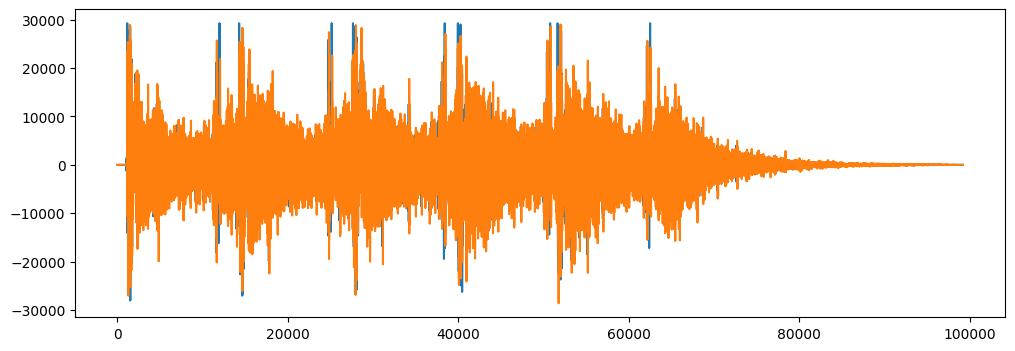

(60, 97)


,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [3]:
# Firstly lets we look to a single audio file that we can plot our audio file
audio_file_path = 'UrbanSound8K/audio/fold1/7061-6-0-0.wav'
librosa_audio_data, librosa_sample_rate = librosa.load(audio_file_path)

# Only 1 channels
plt.figure(figsize=(12, 4))
plt.plot(librosa_audio_data)
plt.show()

wave_sample_rate, wave_audio = wav.read(audio_file_path)
print(wave_sample_rate)

plt.figure(figsize=(12, 4))
plt.plot(wave_audio)
plt.show()

# Feature Extraction
mfccs = librosa.feature.mfcc(y= librosa_audio_data, sr= librosa_sample_rate, n_mfcc=60) # n_mfcc: number of MFCCs of return
print(mfccs.shape)

# We will extract MFCC's for every audio file in the dataset..
audio_dataset_path = 'UrbanSound8K/audio/'
metadata = pd.read_csv('UrbanSound8K/metadata/UrbanSound8K.csv')
metadata.head()

# Preprocessing

In [4]:
def features_extractor(file_name):
    audio, sample_rate = librosa.load(file_name)
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=60)
    mfccs_scaled_features = np.mean(mfccs_features.T, axis=0)

    return mfccs_scaled_features

# Now we iterate through every audio file and extract features - using MFCC
extracted_features=[]
for index_num,row in tqdm(metadata.iterrows()):
    file_name = os.path.join(os.path.abspath(audio_dataset_path),'fold'+str(row["fold"])+'/',str(row["slice_file_name"]))
    final_class_labels=row["class"]
    data=features_extractor(file_name)
    extracted_features.append([data,final_class_labels])

extracted_features_df = pd.DataFrame(extracted_features, columns=['feature', 'class'])
extracted_features_df.head()

8732it [03:42, 39.32it/s] 


,feature,class
0,"[-211.93698, 62.581215, -122.813156, -60.74529...",dog_bark
1,"[-417.0052, 99.336624, -42.995586, 51.073326, ...",children_playing
2,"[-452.39316, 112.36253, -37.57807, 43.195866, ...",children_playing
3,"[-406.47922, 91.1966, -25.043556, 42.78452, 11...",children_playing
4,"[-439.63873, 103.86223, -42.658783, 50.690285,...",children_playing


In [5]:
extracted_features_df.shape

(8732, 2)

In [6]:
# Data augmentation
# Noise injection
def add_noise(audio_data, noise_factor):
    noise = np.random.randn(len(audio_data))
    augmented_data = audio_data + noise_factor * noise
    return augmented_data

# Apply data augmentation
def apply_augmentation(features_df, shift_max=5, noise_factor=0.005, num_augmented=5):
    augmented_features = []
    
    for index, row in features_df.iterrows():
        feature = row['feature']
        label = row['class']
        
        for i in range(num_augmented):
            augmented_feature = feature.copy()
            # add_noise
            augmented_data = add_noise(augmented_feature, noise_factor)
            # Append feature and label
            augmented_features.append([augmented_data, label])
    
    augmented_df = pd.DataFrame(augmented_features, columns=['feature', 'class'])
    return augmented_df

augmented_data = apply_augmentation(extracted_features_df)

In [7]:
augmented_data.shape

(43660, 2)

In [8]:
x = np.array(augmented_data['feature'].tolist())
y = np.array(augmented_data['class'].tolist())
print(x.shape)
print(y.shape)

(43660, 60)
(43660,)


In [9]:
labelencoder = LabelEncoder()
y = to_categorical(labelencoder.fit_transform(y))

In [10]:
# train-test split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=0)

print(x_train.shape)
print(x_val.shape)
print(x_test.shape)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(27942, 60)
(6986, 60)
(8732, 60)
(27942, 10)
(6986, 10)
(8732, 10)


In [11]:
x_train_tensor = torch.tensor(x_train, dtype=torch.float32).to('cuda')
y_train_tensor = torch.tensor(np.argmax(y_train, axis=1), dtype=torch.long).to('cuda')

x_val_tensor = torch.tensor(x_val, dtype=torch.float32).to('cuda')
y_val_tensor = torch.tensor(np.argmax(y_val, axis=1), dtype=torch.long).to('cuda')

x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
y_test_tensor = torch.tensor(np.argmax(y_test, axis=1), dtype=torch.long)

In [12]:
train_dataset = torch.utils.data.TensorDataset(x_train_tensor, y_train_tensor)
val_dataset = torch.utils.data.TensorDataset(x_val_tensor, y_val_tensor)
test_dataset = torch.utils.data.TensorDataset(x_test_tensor, y_test_tensor)

batch_size = 80
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# MLP Model

In [70]:
class SimpleMLP(nn.Module):
    def __init__(self, input_size, num_classes, dropout_rate=0.5):
        super(SimpleMLP, self).__init__()
        self.fc1 = nn.Linear(input_size, 125)
        self.dropout1 = nn.Dropout(p=dropout_rate)
        self.fc2 = nn.Linear(125, 250)
        self.dropout2 = nn.Dropout(p=dropout_rate)
        self.fc3 = nn.Linear(250, num_classes)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return torch.nn.functional.softmax(x, dim=1)

In [71]:
# Creating Model
input_size = 60
num_classes = 10
dropout_rate = 0.3
mlp_model = SimpleMLP(input_size, num_classes, dropout_rate)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mlp_model.parameters(), lr=0.001)

In [13]:
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0.0
    for batch_inputs, batch_labels in train_loader:
        batch_inputs, batch_labels = batch_inputs.to(device), batch_labels.to(device)
        optimizer.zero_grad()
        outputs = model(batch_inputs)
        loss = criterion(outputs, batch_labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    average_loss = total_loss / len(train_loader)
    return average_loss

def validate(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_inputs, batch_labels in val_loader:
            batch_inputs, batch_labels = batch_inputs.to(device), batch_labels.to(device)
            outputs = model(batch_inputs)
            loss = criterion(outputs, batch_labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += batch_labels.size(0)
            correct += (predicted == batch_labels).sum().item()
    accuracy = correct / total * 100
    average_loss = total_loss / len(val_loader)
    return accuracy, average_loss

In [73]:
num_epochs = 250
mlp_model = mlp_model.to(device)

for epoch in range(num_epochs):
    train_loss = train(mlp_model, train_loader, criterion, optimizer, device)
    train_accuracy, _ = validate(mlp_model, train_loader, criterion, device)
    val_accuracy, _ = validate(mlp_model, val_loader, criterion, device)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Validation Accuracy: {val_accuracy:.2f}%')

Epoch [1/250], Train Loss: 2.1448, Train Accuracy: 43.87%, Validation Accuracy: 43.92%
Epoch [2/250], Train Loss: 2.0094, Train Accuracy: 50.86%, Validation Accuracy: 50.29%
Epoch [3/250], Train Loss: 1.9309, Train Accuracy: 63.29%, Validation Accuracy: 62.83%
Epoch [4/250], Train Loss: 1.8492, Train Accuracy: 65.47%, Validation Accuracy: 65.19%
Epoch [5/250], Train Loss: 1.8264, Train Accuracy: 66.63%, Validation Accuracy: 66.23%
Epoch [6/250], Train Loss: 1.8163, Train Accuracy: 68.14%, Validation Accuracy: 67.28%
Epoch [7/250], Train Loss: 1.8029, Train Accuracy: 69.20%, Validation Accuracy: 68.65%
Epoch [8/250], Train Loss: 1.7934, Train Accuracy: 69.78%, Validation Accuracy: 69.07%
Epoch [9/250], Train Loss: 1.7864, Train Accuracy: 70.86%, Validation Accuracy: 70.44%
Epoch [10/250], Train Loss: 1.7832, Train Accuracy: 71.23%, Validation Accuracy: 70.56%
Epoch [11/250], Train Loss: 1.7750, Train Accuracy: 71.87%, Validation Accuracy: 71.23%
Epoch [12/250], Train Loss: 1.7683, Train

In [14]:
result_classes = ["air_conditioner","car_horn","children_playing","dog_bark","drilling", "engine_idling", "gun_shot", "jackhammer", "siren", "street_music"]

In [86]:
# Predictions
mlp_model.eval()
mlp_model.to('cpu')
with torch.no_grad():
    predict= mlp_model(x_test_tensor)

for i in range(10):
    predicted_classes = result_classes[np.argmax(predict[i].numpy())]
    actual_classes = result_classes[np.argmax(y_test[i])]
    print(f"Gerçek: {actual_classes}, Tahmin: {predicted_classes}")

Gerçek: dog_bark, Tahmin: dog_bark
Gerçek: jackhammer, Tahmin: jackhammer
Gerçek: air_conditioner, Tahmin: air_conditioner
Gerçek: car_horn, Tahmin: car_horn
Gerçek: drilling, Tahmin: drilling
Gerçek: engine_idling, Tahmin: engine_idling
Gerçek: air_conditioner, Tahmin: air_conditioner
Gerçek: children_playing, Tahmin: children_playing
Gerçek: engine_idling, Tahmin: engine_idling
Gerçek: street_music, Tahmin: street_music


In [87]:
# Train Accuracy: 96.25%, Validation Accuracy: 95.39%
torch.save(mlp_model, 'mlp_model.pth')

# CNN Model

In [15]:
# LeNet
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv1d(1, 6, kernel_size=5, padding=2)
        self.pool1 = nn.AvgPool1d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv1d(6, 16, kernel_size=5)
        self.pool2 = nn.AvgPool1d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(16 * 13, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = x.unsqueeze(1)  
        x = self.sigmoid(self.conv1(x))
        x = self.pool1(x)
        x = self.sigmoid(self.conv2(x))
        x = self.pool2(x)
        x = self.flatten(x)
        x = self.sigmoid(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        x = self.fc3(x)
        return torch.nn.functional.softmax(x, dim=1)

In [16]:
# Creating Model and identification device (GPU veya CPU)
cnn_model = SimpleCNN().to(device)

# Loss function and optimizer identify
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=0.01)

In [17]:
num_epochs = 250

for epoch in range(num_epochs):
    train_loss = train(cnn_model, train_loader, criterion, optimizer, device)
    train_accuracy, _ = validate(cnn_model, train_loader, criterion, device)
    val_accuracy, _ = validate(cnn_model, val_loader, criterion, device)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Validation Accuracy: {val_accuracy:.2f}%')

Epoch [1/250], Train Loss: 2.1524, Train Accuracy: 42.69%, Validation Accuracy: 42.97%
Epoch [2/250], Train Loss: 1.9914, Train Accuracy: 52.14%, Validation Accuracy: 52.75%
Epoch [3/250], Train Loss: 1.9186, Train Accuracy: 55.04%, Validation Accuracy: 54.92%
Epoch [4/250], Train Loss: 1.8703, Train Accuracy: 59.22%, Validation Accuracy: 58.50%
Epoch [5/250], Train Loss: 1.8365, Train Accuracy: 64.32%, Validation Accuracy: 63.28%
Epoch [6/250], Train Loss: 1.8083, Train Accuracy: 65.90%, Validation Accuracy: 64.94%
Epoch [7/250], Train Loss: 1.7752, Train Accuracy: 71.33%, Validation Accuracy: 69.58%
Epoch [8/250], Train Loss: 1.7433, Train Accuracy: 73.72%, Validation Accuracy: 72.42%
Epoch [9/250], Train Loss: 1.7242, Train Accuracy: 75.22%, Validation Accuracy: 73.62%
Epoch [10/250], Train Loss: 1.7078, Train Accuracy: 76.27%, Validation Accuracy: 74.82%
Epoch [11/250], Train Loss: 1.6940, Train Accuracy: 78.22%, Validation Accuracy: 76.65%
Epoch [12/250], Train Loss: 1.6839, Train

In [18]:
# Predictions
cnn_model.eval()
cnn_model.to('cpu')
with torch.no_grad():
    predict= cnn_model(x_test_tensor)

for i in range(10):
    predicted_classes = result_classes[np.argmax(predict[i].numpy())]
    actual_classes = result_classes[np.argmax(y_test[i])]
    print(f"Gerçek: {actual_classes}, Tahmin: {predicted_classes}")

Gerçek: dog_bark, Tahmin: dog_bark
Gerçek: jackhammer, Tahmin: jackhammer
Gerçek: air_conditioner, Tahmin: air_conditioner
Gerçek: car_horn, Tahmin: car_horn
Gerçek: drilling, Tahmin: drilling
Gerçek: engine_idling, Tahmin: engine_idling
Gerçek: air_conditioner, Tahmin: air_conditioner
Gerçek: children_playing, Tahmin: children_playing
Gerçek: engine_idling, Tahmin: engine_idling
Gerçek: street_music, Tahmin: street_music


In [19]:
# Train Accuracy: 94.46%, Validation Accuracy: 93.44%
torch.save(cnn_model.state_dict(), 'cnn_model.pth')

# LSTM Model

In [61]:
x_train_tensor = x_train_tensor.unsqueeze(1)  # Sequence length eklemek için unsqueeze kullanılıyor
x_val_tensor = x_val_tensor.unsqueeze(1)  # Sequence length eklemek için unsqueeze kullanılıyor
x_test_tensor = x_test_tensor.unsqueeze(1)  # Sequence length eklemek için unsqueeze kullanılıyor

In [64]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(LSTMModel, self).__init__()
        
        # Define the LSTM layer
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)
        
        # Define the output layer
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(x.device)
        
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))
        
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out

In [65]:
# Instantiate the model
input_dim = x_train_tensor.shape[-1]  # MFCC feature size
hidden_dim = 128
layer_dim = 2  # Number of LSTM layers
output_dim = len(labelencoder.classes_)  # Number of classes

# Creating model
lstm_model = LSTMModel(input_dim, hidden_dim, layer_dim, output_dim).to('cuda')

# Loss Function and  optimization function
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=0.001)

In [67]:
num_epochs = 50
for epoch in range(num_epochs):
    train_loss = train(lstm_model, train_loader, criterion, optimizer, device)
    train_accuracy, _ = validate(lstm_model, train_loader, criterion, device)
    val_accuracy, _ = validate(lstm_model, val_loader, criterion, device)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Validation Accuracy: {val_accuracy:.2f}%')

Epoch [1/50], Train Loss: 0.0545, Train Accuracy: 99.41%, Validation Accuracy: 99.03%
Epoch [2/50], Train Loss: 0.0110, Train Accuracy: 99.79%, Validation Accuracy: 99.44%
Epoch [3/50], Train Loss: 0.0094, Train Accuracy: 99.77%, Validation Accuracy: 99.43%
Epoch [4/50], Train Loss: 0.0077, Train Accuracy: 99.32%, Validation Accuracy: 98.80%
Epoch [5/50], Train Loss: 0.0778, Train Accuracy: 98.72%, Validation Accuracy: 98.24%
Epoch [6/50], Train Loss: 0.0131, Train Accuracy: 99.82%, Validation Accuracy: 99.69%
Epoch [7/50], Train Loss: 0.0060, Train Accuracy: 99.84%, Validation Accuracy: 99.63%
Epoch [8/50], Train Loss: 0.0360, Train Accuracy: 96.97%, Validation Accuracy: 96.31%
Epoch [9/50], Train Loss: 0.0283, Train Accuracy: 99.38%, Validation Accuracy: 98.97%
Epoch [10/50], Train Loss: 0.0109, Train Accuracy: 99.85%, Validation Accuracy: 99.47%
Epoch [11/50], Train Loss: 0.0051, Train Accuracy: 99.86%, Validation Accuracy: 99.70%
Epoch [12/50], Train Loss: 0.0042, Train Accuracy: 9

In [70]:
# Predictions
lstm_model.eval()
lstm_model.to('cpu')
with torch.no_grad():
    predict= lstm_model(x_test_tensor)

for i in range(10):
    predicted_classes = result_classes[np.argmax(predict[i].numpy())]
    actual_classes = result_classes[np.argmax(y_test[i])]
    print(f"Gerçek: {actual_classes}, Tahmin: {predicted_classes}")

Gerçek: dog_bark, Tahmin: dog_bark
Gerçek: jackhammer, Tahmin: jackhammer
Gerçek: air_conditioner, Tahmin: air_conditioner
Gerçek: car_horn, Tahmin: car_horn
Gerçek: drilling, Tahmin: drilling
Gerçek: engine_idling, Tahmin: engine_idling
Gerçek: air_conditioner, Tahmin: air_conditioner
Gerçek: children_playing, Tahmin: children_playing
Gerçek: engine_idling, Tahmin: engine_idling
Gerçek: street_music, Tahmin: street_music


In [72]:
# Train Accuracy: 99.49%, Validation Accuracy: 99.14%
torch.save(lstm_model, 'lstm_model.pth')